### Background checks

This nootebook tests the sampling of the background. We simulate only the background and we then fit it, leaving the tilt and normalization parameters free to vary.

In [1]:
cd ..

/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling


In [2]:
import make

In [3]:
from pathlib import Path
import logging
import warnings
import click
import multiprocessing
from itertools import repeat

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.convolution import Tophat2DKernel
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.data import GTI, Observation, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import LiMaMapEstimator as lima
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.estimators import ImageProfile, ImageProfileEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import Models
from gammapy.utils.table import table_from_row_data
from regions import CircleSkyRegion

import copy
import numpy as np
import astropy.units as u
from astropy.table import Table
import gammapy
from gammapy.data import EventList
from gammapy.maps import MapCoord
from gammapy.modeling.models import BackgroundModel, ConstantTemporalModel
from gammapy.utils.random import get_random_state
import yaml


In [4]:
cd checks

/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/checks


In [5]:
def prepare_dataset(filename_dataset):
    """Prepare dataset for a given skymodel."""
    log.info(f"Reading {make.IRF_FILE}")
    irfs = load_cta_irfs(make.IRF_FILE)
    observation = Observation.create(
        obs_id=1001, pointing=make.POINTING, livetime=make.LIVETIME, irfs=irfs
    )

    empty = MapDataset.create(make.WCS_GEOM, energy_axis_true=make.ENERGY_AXIS_TRUE, migra_axis=make.MIGRA_AXIS)
    maker = MapDatasetMaker(selection=["exposure", "background"])
    dataset = maker.run(empty, observation)

    filename_dataset.parent.mkdir(exist_ok=True, parents=True)
    log.info(f"Writing {filename_dataset}")
    dataset.write(filename_dataset, overwrite=True)


def prepare_dataset_fit(filename_dataset):
    """Prepare dataset for a given skymodel."""
    log.info(f"Reading {make.IRF_FILE}")
    irfs = load_cta_irfs(make.IRF_FILE)
    observation = Observation.create(
        obs_id=1001, pointing=make.POINTING, livetime=make.LIVETIME, irfs=irfs
    )

    empty = MapDataset.create(WCS_GEOM_fit, energy_axis_true=make.ENERGY_AXIS_TRUE, migra_axis=make.MIGRA_AXIS)
    maker = MapDatasetMaker(selection=["exposure", "background"])
    dataset = maker.run(empty, observation)

    filename_dataset.parent.mkdir(exist_ok=True, parents=True)
    log.info(f"Writing {filename_dataset}")
    dataset.write(filename_dataset, overwrite=True)


def read_dataset_for_fit(filename_dataset, filename_dataset_fit, filename_model, obs_id):
    log.info(f"Reading {filename_dataset_fit}")
    dataset = MapDataset.read(filename_dataset_fit)

    filename_events = make.get_filename_events(filename_dataset, filename_model, obs_id)
    log.info(f"Reading {filename_events}")
    events = EventList.read(filename_events)

    counts = Map.from_geom(WCS_GEOM_fit)
    counts.fill_events(events)
    dataset.counts = counts
    return dataset


def simulate_events(filename_model, filename_dataset, nobs):
    """Simulate events of the bkg and dataset.

    Parameters
    ----------
    filename_model : str
        Filename of the model definition.
    filename_dataset : str
        Filename of the dataset to use for simulation.
    nobs : int
        Number of obervations to simulate.
    """
    log.info(f"Reading {make.IRF_FILE}")
    irfs = load_cta_irfs(make.IRF_FILE)

    log.info(f"Reading {filename_dataset}")
    dataset = MapDataset.read(filename_dataset)

    sampler = MapDatasetEventSampler(random_state=0)

    for obs_id in np.arange(nobs):
        observation = Observation.create(
            obs_id=obs_id, pointing=make.POINTING, livetime=make.LIVETIME, irfs=irfs
        )

        events = sampler.run(dataset, observation)

        path = make.get_filename_events(filename_dataset, filename_model, obs_id)
        log.info(f"Writing {path}")
        path.parent.mkdir(exist_ok=True, parents=True)
        events.table.write(str(path), overwrite=True)
        
    
def fit_model(filename_model, filename_dataset, obs_id, filename_dataset_fit=None):
    """Fit the events using a model.

    Parameters
    ----------
    filename_model : str
        Filename of the model definition.
    filename_dataset : str
        Filename of the dataset to use for simulation.
    obs_id : int
        Observation ID.
    """
    if filename_dataset_fit is not None:
        dataset = read_dataset_for_fit(filename_dataset, filename_dataset_fit, filename_model, obs_id)
    else:
        dataset = make.read_dataset(filename_dataset, filename_model, obs_id)

    dataset.background_model.parameters["norm"].frozen = False
    dataset.background_model.parameters["tilt"].frozen = False
    
    fit = Fit([dataset])

#     result = fit.run(optimize_opts={"print_level": 1})
    result = fit.run()

    log.info(f"Fit info: {result}")
    path = make.get_filename_best_fit_model(filename_model, obs_id, make.LIVETIME)
    log.info(f"Writing {path}")
    dataset.models.write(str(path), overwrite=True)
    path = make.get_filename_covariance(path)

    log.info(f"Writing {path}")

    # TODO: exclude background parameters for now, as they are fixed anyway
    covariance = result.parameters.get_subcovariance(dataset.models.parameters)
    np.savetxt(path, covariance)


def fit_gather(model_name, livetime):
    rows = []

    path = (BASE_PATH / f"results/models/{model_name}/fit_{livetime.value:.0f}{livetime.unit}")

    for filename in path.glob("*.yaml"):
        yaml_str = Path(filename).read_text()
        model_best_fit = yaml.safe_load(yaml_str)
        path = make.get_filename_covariance(filename)
        covariance = np.loadtxt(str(path))

        row = {}

        for i in np.arange(len(model_best_fit['components'][0]['parameters'])):
            name=model_best_fit['components'][0]['parameters'][i]['name']
            value=model_best_fit['components'][0]['parameters'][i]['value']
            row[name] = value
            row[name + "_err"] = covariance[i,i]**0.5

        rows.append(row)

    table = table_from_row_data(rows)
    name = f"fit-results-all_{livetime.value:.0f}{livetime.unit}"
    filename = BASE_PATH / f"results/models/{model_name}/{name}.fits.gz"
    log.info(f"Writing {filename}")
    table.write(str(filename), overwrite=True)
    

def plot_pull_distribution(model_name, livetime):
    name = f"fit-results-all_{livetime.value:.0f}{livetime.unit}"
    filename = BASE_PATH / f"results/models/{model_name}/{name}.fits.gz"
    results = Table.read(str(filename))

    dataset = MapDataset.read(filename_dataset)
    dataset.background_model.parameters["tilt"].frozen = False
    model_ref = dataset.models
    names = [name for name in results.colnames if "err" not in name]

    plots = f"plots_{livetime.value:.0f}{livetime.unit}"
    for name in names:
        # TODO: report mean and stdev here as well
        values = results[name]
        values_err = results[name + "_err"]
        par = model_ref.parameters[name]

        if par.frozen:
            log.info(f"Skipping frozen parameter: {name}")
            continue

        pull = (values - par.value) / values_err

#        print("Number of fits beyond 5 sigmas: ",(np.where( (pull<-5) )))
        plt.hist(pull, bins=21, density=True, range=(-5,5))
        plt.xlim(-5, 5)
        plt.xlabel("(value - value_true) / error")
        plt.ylabel("PDF")
        plt.title(f"Pull distribution for {model_name}: {name} ")
        filename = f"results/models/{model_name}/{plots}/pull-distribution-{name}.png"
        make.save_figure(filename)


#### Define additional configuration parameters

In [6]:
log = logging.getLogger(__name__)
BASE_PATH = Path("../make.py").parent

WCS_GEOM_fit = WcsGeom.create(
    skydir=make.POINTING, width=(8, 8), binsz=0.02, 
    frame="galactic", axes=[make.ENERGY_AXIS]
)

### Simulating and fitting the background

In [7]:
change_binning_fit_dataset=True

model = 'background'
filename_model = BASE_PATH / f"models/{model}.yaml"
filename_dataset = make.get_filename_dataset(make.LIVETIME)
filename_dataset_fit = BASE_PATH / "data/dataset_1h_fit.fits.gz"

obs_ids=0

prepare_dataset(filename_dataset)
prepare_dataset_fit(filename_dataset_fit)

simulate_events(filename_model=filename_model, filename_dataset=filename_dataset, nobs=obs_ids)
obs_ids = f"0:{obs_ids}"
obs_ids = make.parse_obs_ids(obs_ids, model)
with multiprocessing.Pool(processes=4) as pool:
    if change_binning_fit_dataset==False:
        args = zip(repeat(filename_model), repeat(filename_dataset), obs_ids)
    else:
        args = zip(repeat(filename_model), repeat(filename_dataset), obs_ids, 
                   repeat(filename_dataset_fit))
    results = pool.starmap(fit_model, args)

fit_gather(model,make.LIVETIME)
plot_pull_distribution(model, make.LIVETIME)

#### Histogram of the simulated bkg events

In [10]:
model = 'background'
obsid=0
filename_events = (BASE_PATH / f"data/models/{model}/events_{make.LIVETIME.value:.0f}{make.LIVETIME.unit}_{obsid:04d}.fits.gz")
events = EventList.read(filename_events)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x119014ac8>)

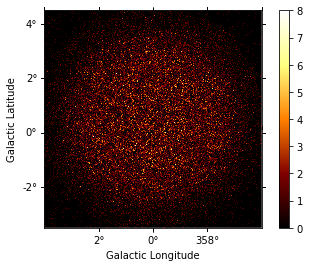

In [11]:
counts = Map.create(frame="galactic", skydir=make.POINTING, width=(8, 8), binsz=0.02)
counts.fill_events(events)
counts.plot(add_cbar=True)

In [11]:
p = ImageProfileEstimator(method='sum', axis='radial', center=make.POINTING)
profile = p.run(counts)

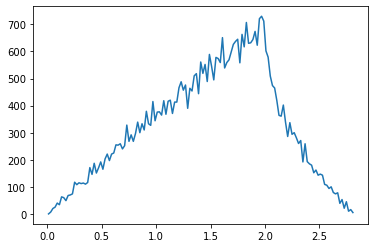

In [12]:
dr = (profile.table['x_max']-profile.table['x_min'])
x = profile.table['x_ref']
y = profile.table['profile']
plt.plot(x,y)

#### Energy histogram of the simulated bkg events

[]

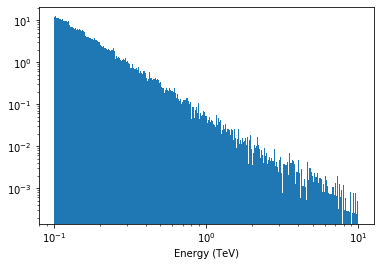

In [14]:
hist = plt.hist(events.table['ENERGY'], bins=np.logspace(-1,1,500), 
                density=True, log=True)
plt.xlabel("Energy (TeV)")
plt.loglog()